Here is JINT code + adaptation to the real world.
# Contents


[**Racionale**](#proveThePoint)

**Hardware**
- [Decide flight platform and ros version](#flightPlatform)
- [Hardware Architecture](#hardwareArchitecture)

**Development Environment**
- [Method](#method)
- [Nvidia](#Nvidia)
- [Docker](#dockerFile)
- [Gazebo simulation](#gazebo)
    - [Try 4 -  octomap camera](#try4)
    - [Try 5 -  velodyne adaptation](#try5)
    - [Try 6 -  older px4 sitl from 2015](#try6)
    - [Try 7 -  hector quadrotor](#try7)
    - [Try 8 -  grvc + px4](#try8)
    - [Try 9 -  try5 ETHz onwards](#try9)
    
**Software**
- [Implementation Particularities](#implementation_particularities)
- [Baseline and variations](#variations)
- [Architecture](#architecture)
- [Ros Mysteries](#rosMysteries)
- [MavRos](#mavros)
- [How to test](#testing)

[**Experiment**](#experiment)
- [Simulation environment](#Simulation_environment)
- [Steps](#Steps)
- [Dataset](#dataset)
- [What to measure](#What_to_measure)
- [Hardware Setup](#hardware_setup)
    - [Try 1 - ASL](#try1_asl)
    - [Try 2 - CATEC](#try2_catec)
- [Hardware in the loop](#hitl)
- [Instructions to test](#test_instructions)
- [Thinkpad](#thinkpad)
- [Launching instructions](#LaunchingInstructions)

[**Data analysis**](#data_analysis)

[**Implementation details**](#Implementation)

**Result analysis - Were there any improvements?**

The data to be used will be the flights in the testbed.

- RAM memory implications
- Computation time of paths

[**Milestones**](#Milestones)

**Bibliography**(#References)



[test link](Paper A.ipynb)

<a id='proveThePoint'></a>
# Racionale

This approach adds the abitility to inspect any building, without any prior knowledge (not even on google maps), in all space of the 3 dimensions (not just ground or pillars or wall).

The final tests must prove it works on the target scale (oilrigs). This will be done through scaling the bootleneck points (distances, memory, sensor resolution). [study here](Paper C - Large structures test.ipynb#scaling) and  [calculation sheet](https://docs.google.com/spreadsheets/d/1UFneS__9-L0viD8dhHrdOTUGh9j_4SgYT0UNm2cHwcY/edit?usp=sharing)

Obstacle avoidance online.

It would be nice to do a table of the available experiments defining a features like "A Multirobot System for Distributed Area Coverage and Signal Searching in Large Outdoor Scenarios" table 1

<a id='flightPlatform'></a>
# Flight platform & software requirements

- **Payload** Point cloud sensor + camera for later mapping
- **Autopilot** Pixhawk 1 (for vicon compatibility)
- **Onboard CPU/GPU** UPboard
- **Vicon interface** is ROS_VRPN_CLIENT, working with Pixhawk 1 (Fran has experience)
- [**Gazebo out of the box**](http://gazebosim.org/tutorials?tut=ros_wrapper_versions#Gazebo7.xseries) 
    - Kinetic works with Gazebo 8 and Xenial [here](https://github.com/CentroEPiaggio/iliad_wiki/wiki/1.-ROS-Kinetic-and-Gazebo8-setup) is an installation guide
    - [Docker with PxHawk + Gazebo + mavros](https://dev.px4.io/en/test_and_ci/docker.html)
- **Ros version** (see above)
- **Docker** Likely yes 

[Excel for calculations](http://localhost:8888/?token=87db5327c113e4e5779dc262cbc3c08597b230f34cb1927c
)

<a id='hardwareArchitecture'></a>
# Hardware Architecture

![component_connection_diagram](attachment:component_connection_diagram)

<a id='method'></a>
### Method

1. Docker - Evironment encapsulation. Summarize initial setup needed to reproduce experiment. Enable generate easily a new machine. Open the possiblity of quick fresh install, having different versions without the added complexity of making sure the right version of each tools is being used while alternating among investigation lines.
1. Git - keep track of development
1. Jupyter notebook - keep track of investigation progress recording abandoned paths, dead ends and mistakes. 
1. Synthesis matrix - comparing each analyzed aspect of each possibility. Forgotten aspects show up and also with certain problems didn't come up at each point.
1. Record aditional setup needed to start experiment. (also jupyter)
1. Unit testing. Assert code stability. Record api usage. Record development focus.
1. Gazebo. More plugins for sensors.
1. Match the simulated architecture with the UAV architecture as closely as possible (example Real-time visual-inertial mapping, re-localization and planning onboard MAVs in unknown environments p4)


<a id='Nvidia'></a>
### Nvidia 

The nvidia GPU drivers make a mess with docker. The best option is to just burn the whole thing with fire.

To do so follow [this guy](https://askubuntu.com/questions/206283/how-can-i-uninstall-a-nvidia-driver-completely)

Blacklisting does not work (or boot)

To check what is being used when nvidia is installed between the intel and nvidia: `prime-select query`

When the installation is correct the command is no longer recognized.

But if you by some reason need to alternate among the two it's `prime-select nvidia|intel`
    
The open source driver made the omen laptop stop working at all for two times. Seemingly at random.

Without GPU there are no additional monitors.

<a id='dockerFile'></a>
### Docker file


Problems with the networking part of things. Especially the GUI interface. Gui will be used for development for visual check of path generated (Lazy Theta*) and understanding the patterns generated by automated exploration. 

On the other hand, the big contribution of docker would be to run simultaneously experiments with different parameters, if these need visual confirmation it's pointless. 

BIG QUESTIONS: 
- How do I automate the assertion of the validity of a run? 
- How do I make videos for dissemination? (this is actually easy, just run locally one that you want to tape)

###### Following [Network Setup tutorial](http://wiki.ros.org/ROS/NetworkSetup) in same container
This turn out to be harder than anticipated. Made a question in [ROS Answers](https://answers.ros.org/question/273281/unable-to-setup-docker-on-kinetic/). Progress:
- If I start roscore on one bash of the container, it is not found on another bash of the same container. Looking into environment variables --> it seems I need to do `export ROS_MASTER_URI=http://172.17.0.2:11311/'

Instructions so far, using garuda as the name of the container: 

1. Start the container 
```
sudo docker run --name garuda -it osrf/ros:kinetic-desktop-xenial
```
    
2. In the local machine find container's IP
```
docker inspect garuda | grep IP
```
    
3. Install minimum stuff and start roscore
```
apt-get update
apt-get install wget
wget http://packages.ros.org/ros.key -O - |  apt-key add -
apt-get update
apt-get install python-catkin-tools
export ROS_MASTER_URI=http://<ip>:11311/
roscore
```    
4. Go to a different terminal and start the listener
```
docker exec -it garuda bash
export ROS_MASTER_URI=http://<ip>:11311/
source /opt/ros/ROS_DISTRO/setup.bash
rosrun rospy_tutorials listener.py
```
5. Go to yet another different terminal and start the talker 
```
docker exec -it garuda bash
export ROS_MASTER_URI=http://<ip>:11311/
source /opt/ros/$ROS_DISTRO/setup.bash
rosrun rospy_tutorials talker.py
```

###### Setup communication as two networked ROS machines, one docker and the other normal desktop. Following [Network Setup tutorial](http://wiki.ros.org/ROS/NetworkSetup)
1. Start the container with [-P flag was used to automatically map any network port inside it to a random high port within an ephemeral port range on your Docker host](https://docs.docker.com/engine/userguide/networking/default_network/dockerlinks/)
```
sudo docker run --name garuda -P -it osrf/ros:kinetic-desktop-xenial
```

2. Same but after `export ROS_MASTER_URI` run `export ROS_IP=<container ip>`

3. Same but after `export ROS_MASTER_URI` run `export ROS_IP=<container ip>`

4. Same but in local machine. 
    - Roscore hears the message but issues the following warning `Couldn't find an AF_INET address for [mfaria-Workstation]`.
    - If additionally the ROS_IP is set to the local machine IP it does not work and no message appears on roscore. 

###### Docker-compose
From the PhD student that setup the farms at OSRF an [example to use docker with docker-compose](https://gist.github.com/ruffsl/4a24c26a1aa2cc733c64)

1. [Install docker compose](https://docs.docker.com/compose/install/#install-compose) 
```sudo curl -L https://github.com/docker/compose/releases/download/3.2.0/docker-compose-`uname -s`-`uname -m` -o /usr/local/bin/docker-compose
sudo chmod +x /usr/local/bin/docker-compose```
2. Create a file with the files on the [gist](https://gist.github.com/ruffsl/4a24c26a1aa2cc733c64) and go there
3. `docker-compose up`
The original example is in indigo. If this works will need to upgrade TODO
4. The containers can talk with each other perfectly and the host can ping all of them. Meaning the following instructions work:

```
ping master
ping talker
ping listener```

However listing topics does not:

```ROS_MASTER_URI=http://master:11311
rostopic list
ERROR: Unable to communicate with master!
```

This was done with composer version 1.16.0 instead of the intended 1.6.2. Will revert to correcto composer version and try again.

###### Possible options for setting up the network
- I did not understood why the previous fails, as the inner workings of AF_INET and hosts are still unclear. However the developer involved in creating Open Source Robotics Foundation's farms contibuted a way of [launching several containers with docker-composer](https://gist.github.com/ruffsl/4a24c26a1aa2cc733c64).
- [Q Change hosts file](https://answers.ros.org/question/254269/docker-ros-unable-to-communicate-with-master/)
- [Q Remove network isolation](https://answers.ros.org/question/250054/how-to-use-docker-on-a-host-together-with-non-docker-machines-ros/)
- [Q Use vm network ip in ROS_MASTER_URI instead of domain name, for VM](https://answers.ros.org/question/227934/roscore-on-virtual-machine/)
- Checkout the docs for [intel aero platform with docker](https://github.com/intel-aero/meta-intel-aero/wiki/08-Aero-Network-and-System-Administration#sysadmin-docker-ros)

###### Docker for px4 + gazebo

[Installation guide](https://dev.px4.io/en/test_and_ci/docker.html)
It is not a very good one.
So far I additionally had to do:
1. create a dedicated folder 
1. cd into it
1. `git clone https://github.com/PX4/Firmware.git`
1. only then start on the installation guide. The provided command was adapted into <pre><code>docker run -it --privileged -v \`pwd\`:\`pwd\`:rw -v /tmp/.X11-unix:/tmp/.X11-unix:ro -e DISPLAY=:0 -p 14556:14556/udp --name=px4_gazebo px4io/px4-dev-ros:2017-05-31 bash</code></pre>
1. Then leave to enter as root
<pre><code>exit
xhost +
docker exec -u 0 -it px4_gazebo bash</pre></code>
1. Go into the Firmware folder and continue the installation
<pre><code>make posix_sitl_default gazebo</pre></code>

Issue submitted to px4 [here](https://github.com/PX4/containers/issues/81)

Need to do `xhost +` every time, but after that gazebo works. As does everything else.

**Seemed final but had the mount permission issue for workspace**

Created Dockerfile with px4-dev-ros:2017-10-23 as base and px4 firmware tag v1.6.5 (on git)

Built with  `sudo docker build -t garuda_sitl .` while at _docker folder

To launch:
1. `xhost +`
2. `docker run -it --privileged -v /home/mfaria/ws_mavlink_grvcHal/:/home/user/ros_workspace:rw -v /tmp/.X11-unix:/tmp/.X11-unix:ro -e DISPLAY=:0 -p 14556:14556/udp --name=px4_gazebo garuda_sitl bash`
3. `exit`
4. `docker start px4_gazebo`
4. `docker exec -u 0 -it px4_gazebo bash`
5. Go into the Firmware folder and continue the installation `make posix_sitl_default gazebo`


###### Firmware by volume mount

- Removed clone from dockerfile
- Launching as `docker run -it --privileged \
    -v /tmp/.X11-unix:/tmp/.X11-unix:ro \
    -e DISPLAY=:0 \
    --name=garuda_sitl px4io/px4-dev-ros:2017-12-08 /bin/bash`
- Launching as `sudo docker run -it --privileged     -v /home/mfaria/Flying_Octomap:/ros_ws     -v /tmp/.X11-unix:/tmp/.X11-unix:ro     -e DISPLAY=:0     --name=garuda_sitl px4io/px4-dev-ros:2017-12-08 /bin/bash`
- From docker px4io/px4-dev-ros tag 2017-12-08
    1. Clone Firmware folder
        1. Download git `git clone https://github.com/PX4/Firmware.git`
        1. Change to tag `git checkout v1.7.0-rc4`
    2. Build docker image
        1. `cd /home/mfaria/Flying_Octomap/src/_docker`
        1. Built with  `docker build -t garuda_sitl .`
    3. Launch docker
        1. `xhost +`
        1. Lauch docker `docker run -it --privileged \
        -v /home/mfaria/docker_px4/Firmware:/Firmware:rw \
        -v /home/mfaria/Flying_Octomap/src:/ros_ws/src:rw \
        -v /tmp/.X11-unix:/tmp/.X11-unix:ro \
        -e DISPLAY=:0 \
        --name=garuda_sitl px4io/px4-dev-ros:2017-12-08 /bin/bash`
        1. exit
        1. `docker start garuda_sitl`
        1. `docker exec -u 0 -it garuda_sitl bash`
    1. Make ros workspace:
        1. `source /opt/ros/kinetic/setup.bash`
        2. `catkin_make`
    1. To launch gazebo: 
        1. `cd /Firmware`
        1. `make posix_sitl_default gazebo`
- From docker custom image garuda_sitl_v2 based on px4io/px4-dev-ros tag 2017-12-08
    1. Clone Firmware folder
        1. Download git `git clone https://github.com/PX4/Firmware.git`
        1. Change to tag `git checkout v1.7.0-rc4`
    2. Build docker image
        1. Built with  `docker build -t garuda_sitl_v2 .` while at _docker folder
    3. Launch docker
        1. `xhost +`
        1. Lauch docker `docker run -it --privileged \
        -v /home/mfaria/docker_px4/Firmware:/Firmware:rw \
        -v /home/mfaria/Flying_Octomap/src:/ros_ws/src:rw \
        -v /tmp/.X11-unix:/tmp/.X11-unix:ro \
        -e DISPLAY=:0 \
        --name=garuda_sitl_v2 garuda_sitl_v2 /bin/bash`
        1. exit
        1. `docker start garuda_sitl_v2`
        1. `docker exec -u 0 -it garuda_sitl_v2 bash`
    1. Make ros workspace:
        1. `source /opt/ros/kinetic/setup.bash`
        1. `cd /ros_ws`
        2. `catkin init`
    1. Build project:
        1. `catkin build` (should take around 3 min)
    1. To launch gazebo: 
        1. `cd /Firmware`
        1. `make posix_sitl_default gazebo`

<a id='gazebo'></a>
# Gazebo and px4 SITL and MavRos

[PixHawk Offboard mode](https://dev.px4.io/en/ros/offboard_control.html)

##### Overlaying for launch
[Overlaying docs](http://wiki.ros.org/catkin/Tutorials/workspace_overlaying)
[Launching gazebo and pc4 separatly docs](https://dev.px4.io/en/simulation/ros_interface.html)

** Try 1 **
1. Docker
    1. Clone Firmware folder
        1. Download git `git clone https://github.com/PX4/Firmware.git`
        1. Change to tag `git checkout v1.7.0-rc4`
    2. Build docker image
        1. Built with  `docker build -t garuda_sitl_v2 .` while at _docker folder
    3. Launch docker
        1. `xhost +`
        1. Lauch docker `docker run -it --privileged \
        -v /home/mfaria/docker_px4/Firmware:/Firmware:rw \
        -v /home/mfaria/ws_mavlink_grvcHal/src:/ros_ws/src:rw \
        -v /tmp/.X11-unix:/tmp/.X11-unix:ro \
        -e DISPLAY=:0 \
        --name=garuda_sitl_v2 garuda_sitl_v2 /bin/bash`
        1. exit
        1. `docker start garuda_sitl_v2`
        1. `docker exec -u 0 -it garuda_sitl_v2 bash`
1. Build with overlay
    1. Build base = px4. Keep terminal
        1. `cd /Firmware`
        1. `no_sim=1 make posix_sitl_default gazebo`
    1. Build overlay
        1. New terminal (check launch docker)
        1. (First time) Make ros workspace:
            1. `source /opt/ros/kinetic/setup.bash`
            1. `cd /ros_ws`
            2. `catkin init`
        1. `catkin build` (should take around 3 min)
        1. Launch gazebo w/ iris
            1. `roslaunch gazebo_ros empty_world.launch world_name:=/Firmware/Tools/sitl_gazebo/worlds/iris.world`
        
** Try 2 **
1. Docker
    1. Clone Firmware folder
        1. Download git `git clone https://github.com/PX4/Firmware.git`
        1. Change to tag `git checkout v1.7.0-rc4`
    2. Build docker image
        1. Built with  `docker build -t garuda_sitl_v2 .` while at _docker folder
    3. Launch docker
        1. `xhost +`
        1. `docker run -it --privileged \
        -v /home/mfaria/docker_px4/Firmware:/Firmware:rw \
        -v /home/mfaria/Flying_Octomap_code/src:/ros_ws/src:rw \
        -v /tmp/.X11-unix:/tmp/.X11-unix:ro \
        -e DISPLAY=:0 \
        --name=garuda_sitl_v2 garuda_sitl_v2 /bin/bash`
        1. exit
        1. `docker start garuda_sitl_v2`
        1. `docker exec -u 0 -it garuda_sitl_v2 bash`
1. Build ros workspace
    1. (First time) Make ros workspace:
        1. `source /opt/ros/kinetic/setup.bash`
        1. `cd /ros_ws`
        2. `catkin init`
    1. `catkin build` (should take around 3 min)
1. Build following [px4](https://dev.px4.io/en/simulation/ros_interface.html) instructions - keep terminal
    1. `cd /Firmware`
    1. `make posix_sitl_default gazebo`
    1. Kill process (this was just for the make part, they apperantly complicated the toolchain at px4)
    1. `source /ros_ws/devel/setup.bash`
    1. `source Tools/setup_gazebo.bash /Firmware /Firmware/build/posix_sitl_default`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware/Tools/sitl_gazebo`
    1. `roslaunch px4 posix_sitl.launch`
1. New terminal
    1. `xhost +`
    1. `docker exec -u 0 -it garuda_sitl_v2 bash`
    1. `cd /Firmware`
    1. `source /ros_ws/devel/setup.bash`
    1. `source Tools/setup_gazebo.bash /Firmware /Firmware/build/posix_sitl_default`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware/Tools/sitl_gazebo`
1. Launch mavros node `roslaunch mavros px4.launch fcu_url:="udp://:14540@127.0.0.1:14557"`
1. In new terminal, launch offboard node `rosrun architecture px4_mavros_offboard_node`


** Try 3 - px4 lidar with lidar **

No good because is a point cloud in LaserScan format. This is kind of merged with try 5.

[Thread with lidar code from px4](https://github.com/PX4/Firmware/pull/6558)
`roslaunch px4 posix_sitl.launch vehicle:=iris_rplidar est:=lpe`


<a id='try4'></a>
** Try 4 - px4 support for octomap ** 

No good because is Point Cloud from camera & for fixed wing.

[Rotors Simulator setup](https://github.com/ethz-asl/rotors_simulator/wiki/Setting-up-the-RotorS-Simulator)
the latest launch seems to be at "Setting up RotorS as Fixed Wing HiL Simulation (Pixhawk, Mavros, Mavlink, QGC)" but it is fixed wing and camera

[pX4 OCTOMAP in simulation](https://dev.px4.io/en/simulation/gazebo_octomap.html) `roslaunch rotors_gazebo mav_hovering_example_with_vi_sensor.launch  mav_name:=firefly`

1. Docker
    2. Build docker image from _docker_vision
        1. In Dockerfile add dependencies 
        ```ros-kinetic-rqt-gui 
        ros-kinetic-rqt-gui-py 
        ros-kinetic-xacro 
        ros-kinetic-robot-state-publisher 
        ros-kinetic-joint-state-publisher```
        1. Also add commands:
        ```
        && mkdir /eth_ws \
        && mkdir /eth_ws/src \
        && cd /eth_ws/src \
        && git clone https://github.com/ethz-asl/rotors_simulator.git \
        && git clone https://github.com/ethz-asl/mav_comm.git \
        && git clone https://github.com/ethz-asl/glog_catkin.git \
        && git clone https://github.com/catkin/catkin_simple.git \
        ```
        1. Built with  `docker build -t garuda_sitl_vision .` while at _docker_vision folder
    3. Launch docker
        1. `xhost +`
        1. `docker run -it --privileged \
        -v /home/mfaria/docker_px4/Firmware:/Firmware:rw \
        -v /home/mfaria/Flying_Octomap_code/src:/ros_ws/src:rw \
        -v /tmp/.X11-unix:/tmp/.X11-unix:ro \
        -e DISPLAY=:0 \
        --name=garuda_sitl_vision garuda_sitl_vision /bin/bash`
        1. exit
        1. `docker start garuda_sitl_vision`
        1. `docker exec -u 0 -it garuda_sitl_vision bash`
1. Build ETH workspace
    1. (First time) Make ETH workspace:
        1. `source /opt/ros/kinetic/setup.bash`
        1. `cd /eth_ws`
        2. `catkin init`
    1. `catkin build` (should take around  min)
1. New terminal
    1. `xhost +`
    1. `docker exec -u 0 -it garuda_sitl_vision bash`
    1. `cd /Firmware`
    1. `source /ros_ws/devel/setup.bash`
    1. `source /eth_ws/devel/setup.bash`
    1. `source Tools/setup_gazebo.bash /Firmware /Firmware/build/posix_sitl_default`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware/Tools/sitl_gazebo`
1. Launch mavros node `roslaunch mavros px4.launch fcu_url:="udp://:14540@127.0.0.1:14557"`
1. In new terminal, launch offboard node `rosrun architecture px4_mavros_offboard_node`



<a id='try5'></a>
** Try 5 - add velodyne to iris **


- Everything seems well (topic has messages, tf frame of messages is connected with the fized frame (base_link)) but no points are shown. [Gazebo question](https://community.gazebosim.org/t/rrbot-tutorial-gazebo-and-rviz/73) [Ros question](https://answers.ros.org/question/279283/pointcloud-from-velodyne-in-rviz/) [Px4 issue](https://github.com/PX4/sitl_gazebo/issues/159)
- Problem with tf tree [issue](https://github.com/PX4/sitl_gazebo/issues/159). Possible solution [converting sdf/xacro to urdf](http://answers.gazebosim.org/question/4192/problem-with-sdf-files-or-robot_description-parameter/) Needed to convert to urdf + robot_state_publisher + joint_state_publisher.
- Pay attention to the paths with not finding the plugin / model. [Environment Variables](http://gazebosim.org/tutorials?tut=components)

- Use the Velodyne sim. Output PointCloud2.

-  pandora / grvcQuadrotor / grvc_quadrotor_gazebo / urdf / grvc_quadrotor_base_velodyne.urdf.xacro 

```<VLP-16 parent="${base_frame}" name="velodyne_down" topic="/${model_name}/velodyne_points/down">
  <origin xyz="-0.1 -0.1 -0.2" rpy="0 0 0" />
</VLP-16>```

-  pandora / dependencies / velodyne_simulator / velodyne_description / urdf / VLP-16.urdf.xacro 
 
```<scan>
    <horizontal>
      <samples>500</samples>
      <resolution>1</resolution>
      <min_angle>-${M_PI}</min_angle>
      <max_angle> ${M_PI}</max_angle>
    </horizontal>
    <vertical>
      <samples>16</samples>
      <resolution>1</resolution>
      <min_angle>-${15.0*M_PI/180.0}</min_angle>
      <max_angle> ${15.0*M_PI/180.0}</max_angle>
    </vertical>
</scan>```

1. Docker
    1. Clone Firmware folder
        1. Download git `git clone https://github.com/PX4/Firmware.git`
        1. Change to tag `git checkout v1.7.0-rc4`
        1. [Deprecated] In file Firmaware /Tools/sitl_gazebo/models/rotors_description/urdf/iris.xacro Add at line 149 
        ```
        <xacro:include filename="/opt/ros/kinetic/share/velodyne_description/urdf/VLP-16.urdf.xacro"/> 
  <VLP-16 parent="base_link" name="velodyne" topic="/velodyne_points" hz="10" samples="440"> 
    <origin xyz="0 0 0.4" rpy="0 0 0" /> 
  </VLP-16>
  ```
    2. Build docker image
        1. Built with  `docker build -t garuda_sitl_v2 .` while at _docker folder
    3. Launch docker
        1. `xhost +`
        1. `docker run -it --privileged \
        -v /home/mfaria/Firmware:/Firmware:rw \
        -v /home/mfaria/Flying_Octomap_code:/ros_ws/src:rw \
        -v /tmp/.X11-unix:/tmp/.X11-unix:ro \
        -e DISPLAY=:0 \
        --name=garuda_sitl_v2 garuda_sitl_v2 /bin/bash`
        1. exit
        1. `docker start garuda_sitl_v2`
        1. `docker exec -u 0 -it garuda_sitl_v2 bash`
1. Build ros workspace
    1. (First time) Make ros workspace:
        1. `source /opt/ros/kinetic/setup.bash`
        1. `cd /ros_ws`
        2. `catkin init`
    1. `catkin build` (should take around 3 min)
1. Build following [px4](https://dev.px4.io/en/simulation/ros_interface.html) instructions - keep terminal
    1. `cd /Firmware`
    1. `make posix_sitl_default gazebo`
    1. Kill process (this was just for the make part, they apperantly complicated the toolchain at px4)
    1. Deprecated Change /Firmware/Tools/sitl_gazebo/models/iris/irirs.sdf At frameName change to local_origin
    1. `source /ros_ws/devel/setup.bash`
    1. `source Tools/setup_gazebo.bash /Firmware /Firmware/build/posix_sitl_default`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware/Tools/sitl_gazebo`
    1. `cp /ros_ws/src/architecture/Tools/iris.xacro /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/`
    1. `cp /ros_ws/src/architecture/Tools/iris_base.xacro /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/`
    1. `cp /ros_ws/src/architecture/Tools/posix_sitl_urdf.launch /Firmware/launch/`
    1. `python /Firmware/Tools/sitl_gazebo/scripts/xacro.py -o /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/iris_base.urdf /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/iris_base.xacro enable_mavlink_interface:=true enable_ground_truth:=false enable_wind:=false enable_logging:=false rotors_description_dir:=/Firmware/Tools/sitl_gazebo/models/rotors_description`
    1. `sed -i 's/package:\/\/rotors_description/package:\/\/mavlink_sitl_gazebo\/models\/rotors_description/g' /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/iris_base.urdf`
    1. Change the vertuical angle of the rays in urdf `sed -i 's/_/_/g' /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/iris_base.urdf`
    1. `roslaunch px4 posix_sitl_urdf.launch`
1. New terminal with ros_ws
    1. `xhost +`
    1. `docker exec -u 0 -it garuda_sitl_v2 bash`
    1. `cd /Firmware`
    1. `source /ros_ws/devel/setup.bash`
    1. `source Tools/setup_gazebo.bash /Firmware /Firmware/build/posix_sitl_default`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware/Tools/sitl_gazebo`
1. New terminal just Firmware
    1. `xhost +`
    1. `docker exec -u 0 -it garuda_sitl_v2 bash`
    1. `cd /Firmware`
    1. `source /opt/ros/kinetic/setup.bash`
    1. `source Tools/setup_gazebo.bash /Firmware /Firmware/build/posix_sitl_default`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware/Tools/sitl_gazebo`
    1. `export PYTHONPATH=$PYTHONPATH:/usr/lib/python2.7/dist-packages` (rqt tools)
1. Launch mavros node `roslaunch mavros px4.launch fcu_url:="udp://:14540@127.0.0.1:14557"`
1. In new terminal, launch offboard node `rosrun architecture px4_mavros_offboard_node`
    
```sudo sh -c 'echo "deb http://packages.ros.org/ros/ubuntu $(lsb_release -sc) main" > /etc/apt/sources.list.d/ros-latest.list' 
sudo apt-key adv --keyserver hkp://ha.pool.sks-keyservers.net:80 --recv-key 421C365BD9FF1F717815A3895523BAEEB01FA116 
wget http://packages.ros.org/ros.key -O - | sudo apt-key add - 
apt-get update ```

The rqt error is harmless so far. But in case it gets relevent [here is how to fix it](
https://github.com/activatedgeek/docker-videostack/issues/1)


<a id='try8'></a>
** Try 8 - grvc for px4 **

[grvc-ual@github](https://github.com/grvcTeam/grvc-ual)

[ros_control](http://gazebosim.org/tutorials/?tut=ros_control) is only for sending commands i.e. for the arms.

1. Get px4 code - Clone Firmware folder
    1. `mkdir ~/px4_grvc`
    1. `cd ~/px4_grvc`
    1. `git clone https://github.com/PX4/Firmware.git`
    1. `cd Firmware/`
    1. `git checkout -f v1.6.3`
    1. `git submodule update --recursive`
1. Docker
    1. At src/_docker_grvc/ folder, build docker image: `docker build -t garuda_sitl_grvc .` 
    1. Launch docker
        1. `xhost +`
        1. `docker run -it --privileged \
        -v /home/mfaria/px4_grvc/Firmware:/Firmware:rw \
        -v /home/mfaria/Flying_Octomap_code/src:/ros_ws/src:rw \
        -v /tmp/.X11-unix:/tmp/.X11-unix:ro \
        -e DISPLAY=$DISPLAY \
        --name=garuda_sitl_grvc garuda_sitl_grvc /bin/bash`
        1. exit
        1. `docker start garuda_sitl_grvc`
        1. `docker exec -u 0 -it garuda_sitl_grvc bash`
1. Build code inside container. Pay attention to the order of ROS_PACKAGE_PATH. Every time the setup.bash is sourced, the Firmware references are wipped out.
    1. `source /opt/ros/kinetic/setup.bash`
    1. `cd /Firmware`
    1. `make posix_sitl_default gazebo`
    1. kill
    1. `source /Firmware/Tools/setup_gazebo.bash /Firmware /Firmware/build/posix_sitl_default`
    1. `cd /ros_ws`
    1. `build init`
    1. `build catkin`
    1. `source devel/setup.bash`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware/Tools/sitl_gazebo`
1. Launch simulation with grvc launch:  `roslaunch px4_bringup test_simulate.launch`
1. Launch rviz vizualization with grvc launch:  `roslaunch robots_description visualize.launch`
1. For new terminals
    1. `xhost +`
    1. `docker exec -u 0 -it garuda_sitl_grvc bash`
    1. `source /Firmware/Tools/setup_gazebo.bash /Firmware /Firmware/build/posix_sitl_default`
    1. `cd /ros_ws`
    1. `source devel/setup.bash`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware/Tools/sitl_gazebo`
1. In new terminal, the commands of architecture px4_mavros_offboard_node
    1. `rostopic pub /uav_1/mavros/setpoint_position/local geometry_msgs/PoseS`
    1. `rosservice call /uav_1/mavros/cmd/takeoff "{min_pitch: 0.0, yaw: 0.0, latitude: 0.0, longitude: 0.0, altitude: 5.0}" `
    1. `rosservice call /uav_1/mavros/cmd/arming "value: true"`
    1. `rosservice call /uav_1/mavros/set_mode "base_mode: 0 custom_mode: 'OFFBOARD'"`

```
std::string ual_ns =  this->ns_prefix_ + std::to_string(this->robot_id_) + "/ual";     
std::string take_off_srv = ual_ns + "/take_off";       
std::string land_srv = ual_ns + "/land";
std::string go_to_waypoint_srv = ual_ns + "/go_to_waypoint";
std::string go_to_waypoint_geo_srv = ual_ns + "/go_to_waypoint_geo";
std::string set_velocity_srv = ual_ns + "/set_velocity";
std::string set_position_error_srv = ual_ns + "/set_position_error";
std::string recover_from_manual_srv = ual_ns + "/recover_from_manual";
std::string pose_topic = ual_ns + "/pose";
std::string velocity_topic = ual_ns + "/velocity";

rosservice call /uav_1/ual/take_off "height: 2.0 blocking: false" 
rosservice call /uav_1/ual/go_to_waypoint_srv 
rosservice call /uav_1/ual/velocity_topic
```

<a id='try9'></a>
##### Try 9 - ETHz

This is after the winter school. Modifications found at ETHz.

Use the Velodyne sim. Output PointCloud2. (? not sure, Riccardo did this)
1. Clone repos
    1. Clone FlyingOctomap folder
        1. `git clone git@github.com:margaridaCF/FlyingOctomap_code.git`
        1. `git checkout ____`
        1. `mv FlyingOctomap_code Flying_Octomap_code`
        1. `cd Flying_Octomap_code`
        1. `git clone git@github.com:margaridaCF/laser_to_free_points_cloud.git`
        1. `cd laser_to_free_points_cloud/`
        1. `git checkout free_cloud `
    1. Clone Firmware folder
        1. `git clone https://github.com/PX4/Firmware.git`
        1. `cd Firmware/`
        1. `git checkout v1.7.0-rc4`
1. Docker
    2. Build docker image
        1. `cd /home/mfaria/Flying_Octomap_code/_docker`
        1. `docker build -t garuda_sitl_v2 .` 
    3. Launch docker
        1. `xhost +`
        1. `docker run -it --privileged \
        -v /home/mfaria/Firmware:/Firmware:rw \
        -v /home/mfaria/Flying_Octomap_code:/ros_ws/src:rw \
        -v /tmp/.X11-unix:/tmp/.X11-unix:ro \
        -e DISPLAY=:0 \
        --name=garuda_sitl_v2 garuda_sitl_v2 /bin/bash`
        1. exit
        1. `docker start garuda_sitl_v2`
        1. `docker exec -u 0 -it garuda_sitl_v2 bash`
1. Build ros workspace
    1. (First time) Make ros workspace:
        1. `cd /Firmware`
        1. `source /opt/ros/kinetic/setup.bash`
        1. `cd /ros_ws`
        2. `catkin init`
    1. `catkin build` 
1. Build following [px4](https://dev.px4.io/en/simulation/ros_interface.html) instructions - keep terminal
    1. `cd /Firmware`
    1. `wget https://raw.githubusercontent.com/mavlink/mavros/master/mavros/scripts/install_geographiclib_datasets.sh`
    1. `chmod +x install_geographiclib_datasets.sh`
    1. `./install_geographiclib_datasets.sh `
    1. `make posix_sitl_default gazebo`
    1. Kill process (this was just for the make part, they apperantly complicated the toolchain at px4)
    1. `source /ros_ws/devel/setup.bash`
    1. `source Tools/setup_gazebo.bash /Firmware /Firmware/build/posix_sitl_default`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware/Tools/sitl_gazebo`
    1. `cp /ros_ws/src/architecture/Tools/iris.xacro /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/`
    1. `cp /ros_ws/src/architecture/Tools/iris_base.xacro /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/`
    1. `cp /ros_ws/src/architecture/launch/posix_sitl_urdf.launch /Firmware/launch/`
    1. `python /Firmware/Tools/sitl_gazebo/scripts/xacro.py -o /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/iris_base.urdf /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/iris_base.xacro enable_mavlink_interface:=true enable_ground_truth:=false enable_wind:=false enable_logging:=false rotors_description_dir:=/Firmware/Tools/sitl_gazebo/models/rotors_description`
    1. `sed -i 's/package:\/\/rotors_description/package:\/\/mavlink_sitl_gazebo\/models\/rotors_description/g' /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/iris_base.urdf`
    1. Change the vertical angle of the rays in urdf `sed -i 's/_/_/g' /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/iris_base.urdf`
    1. `roslaunch px4 posix_sitl_urdf.launch`

1. New terminal with ros_ws
    1. `docker start garuda_sitl_v2`
    1. `xhost +`
    1. `docker exec -u 0 -it garuda_sitl_v2 bash`
    1. `cd /Firmware`
    1. `source /ros_ws/devel/setup.bash`
    1. `source Tools/setup_gazebo.bash /Firmware /Firmware/build/posix_sitl_default`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware/Tools/sitl_gazebo`
1. Launch mavros node `roslaunch mavros px4.launch fcu_url:="udp://:14540@127.0.0.1:14557"`
    


The rqt error is harmless so far. But in case it gets relevent [here is how to fix it](
https://github.com/activatedgeek/docker-videostack/issues/1)

1. To test specific octrees and see results visually (in separate terminals, setup as any other new terminal):
    1. `roslaunch architecture debug_lazyThetaStar.launch`
    1. `rosrun octomap_server octomap_server_node src/path_planning/test/data/d.bt _publish_free_space:=true`


**EUROC setup but with gazebo:**
- Vicon
- Px4 interfacing with ROS [docs](https://dev.px4.io/en/simulation/ros_interface.html)
`roslaunch mavros px4.launch fcu_url:="udp://:14540@127.0.0.1:14557"`

Launch with GDB for headless (?) `make posix_sitl_default gazebo_iris_gdb` from end of [Gazebo + px4 docs](https://dev.px4.io/en/simulation/gazebo.html)

##### Launch file
- Model UAV + hokuyo sensor
- Node auto pilot relay

<a id='software'></a>
# Software

<a id='implementation_particularities'></a>
### Implementation particularities

##### Geofencing safety:
- The very last safety check is done at the mav_comms node but it should be enforced each time a potential waypoint is generated. --> Cannot to this because in the real world the terrain may have negative positions.
- The geofence of the volume to sample is different from the volume to move in. Assuming the space is free around the volume to sample, it is enough to inflate the maneuver space by the safety distance plus 1 meter for discretization misalignment. --> The difference between exploration space and maneuver space is display only. Because of the simplification that reaching the frontier is equal to sampling a point there is no space to decouple these two spaces in a generic way. Some special cases can be made but it reasonable to just say the geofence marks the maneuver space and the guarantees the space will be sampled are only for that geofence minus the safety distance inwards. 
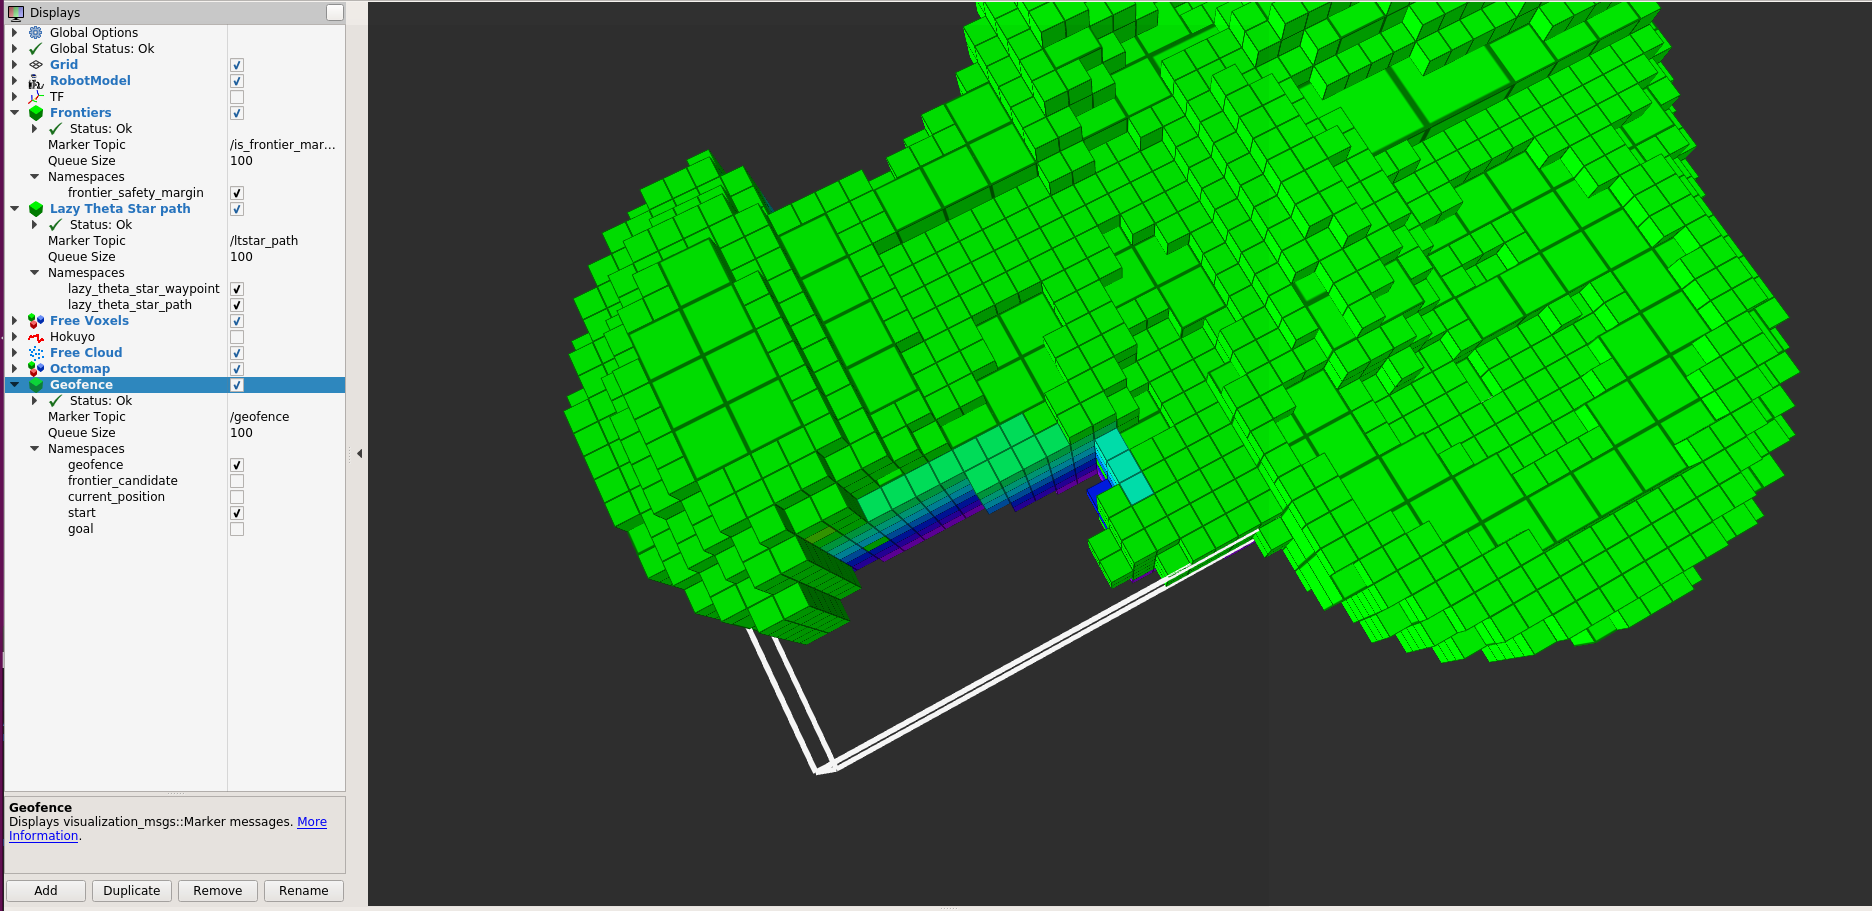

##### Looping nodes:
- Keep a blacklist of unobservable frontiers. Keep it on the frontier node to avoid comms overhead.  ->   In the end loops were always (so far) a result of other issues. Keep an eye out for how many unobservable frontiers are added.
- The loop between frontiers was because of unknown neighbors that were not observable. The immediate problem was solved by only looking for neighbors in positions that are reachable by the sensor (the xy plane). 
- The existing initialization maneuver is not sufficient to create voxels along all the desired z axis. (will be solved in another branch)

##### Single waypoint results
- happened when the start and the goal are in the same voxel. To avoid this situation, it is now part of the operational requirements that this is not an admissible frontier (if UAV is already at the voxel and cannot observe the frontier there is no point staying here).

##### Diagonal neighbors
- They might be important. But before very that the any angle aspect is well implemented.
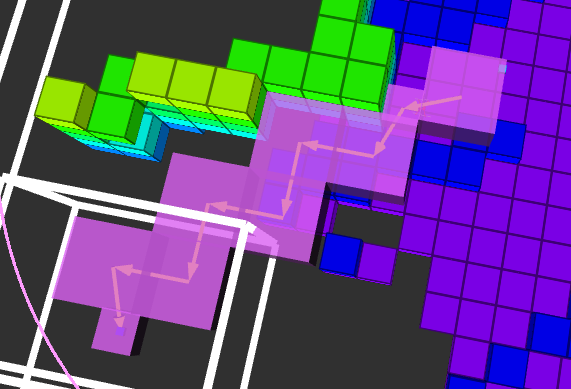

##### When voxels are large
When the size of the voxel is so high that the neighbor cannot be sensed from the center the goal is adjusted to be in a position that takes sensor limitations into account. 
See the code for details on calculation. calculate_closer_position@frontiers.cpp

The calculation of the threshold tales into account the angle the sensor is at. `laser_range_xy = std::cos(laser_angle)*laser_range;`
state_manager_node.cpp @ 420

The xy distance to what is whithin reach is calculated according to sensor angle and range. The frontier generation checks if the frontier can be sensed from the center of the frontier voxel, if this is not the case the generated frontier is adjusted to the sensing range.

##### Last mile unknown as free
Many times the frontier voxels are surronded by unknown space. These are the frontiers with the most potention for exploration. They are also the riskier positions for navigation as an obstacle might suddendly appear. The solution adopted now is to treat unknown  space as free within the safety margin distance. Code at hasLineOfSight & lazyThetaStar_, ignoreUnknown @ ltStar_lib.cpp

##### For frontiers, generate neighbors outside blind spot
The sensor used is has a 10 meter reach in a 270º sorrounding angle. To overcome the lack of information in the z axis, the sensor is mounted titled and an exploration maneuver is introduced upon reaching each frontier. The exploration maneuver is composed of a rotating motion around the z axis while at the frontier coordinates. This extends the range of the area sensed in the z axis but constrains it along xy. It is not sufficient to render the sensor omnidirectional. The shape of the area reached by the sensor resembles a slated donut, where the inside hole is the blind area. The lack of omnidirectionality breaks the assumption that upon reaching the frontier all neighbors can be sampled. The blind area of the Hokuyo is graphically explained in the pictures, seen from the side.

To overcome this limitiation, the generation of neighbors tested to be or not unknown mirrors the shape of the sampled space. The radius of the blind area is calculated by `(frontier_offset + extra) / std::tan(sensor_angle_rad) neighbors.cpp @ generateNeighbors_frontiers_pointers()`.  

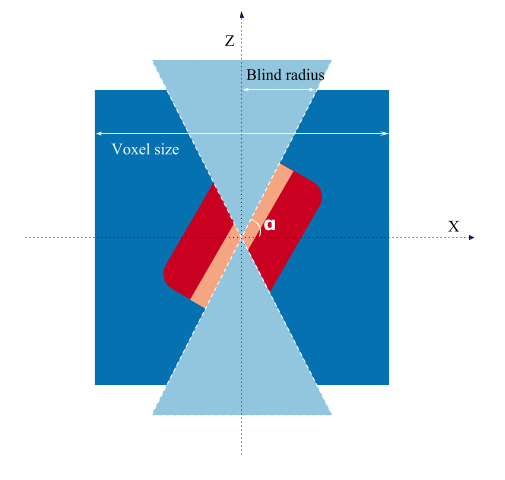

<a id='variations'></a>
### Baseline and variations

##### Baseline

- Frontiers: 
    - Search all frontiers in volume to explore. Pick the closest one.
    - Neighbors are picked up, down, left, right. Scaling with voxel size.

##### Variation 1: Going with the iterator
- Frontiers: 
    - Search until first frontier is found. Using implicit spacial organization of data structure.
    - Neighbors are picked up, down, left, right. Scaling with voxel size.
    
###### Variation 2: Going with the iterator & Adjusting to sensor shape
- Frontiers: 
    - Search until first frontier is found. Using implicit spacial organization of data structure.
    - Neighbors are generating taking into account the shape of the sensor range. Calculating blind cone above. And below?

<a id='architecture'></a>
### Architecture (ROS)

[Architecture diagram](https://docs.google.com/drawings/d/1fRqLOSLiDlbrC7rG28KdJ4CaBSvM_ozNhlzRuhP2z98/edit?usp=sharing)

Hokuyo driver options:
- [urg_node](http://wiki.ros.org/urg_node) LaserScan messages. Stable. Translate with [laser geometry](http://wiki.ros.org/laser_geometry) 
- [Hokuyo 3d](http://wiki.ros.org/hokuyo3d) PointCloud2 messages. Experimental. 
- For simulation use a Velodyne with 270º visibility.

Nodelets:
- Keep single queue for callbacks and spins
- Avoid serialization associated with sockets

Comms options:
- Making a node w/ a service to keep up with current position because the update rate is 100Hz... Probably benefits from nodelets. The frequency is still pretty high but it's the publisher who controls this. If it becomes an issue [topic_tools/throttle](http://wiki.ros.org/topic_tools/throttle) is an option
- The rate of gazebo topics is set on the world file. I  the manual physics part. (ask Helen)
- Drop packages (code on the node) based on the timestamp (wait x amount of time) or the sequence number (only analyze multiples of 100)





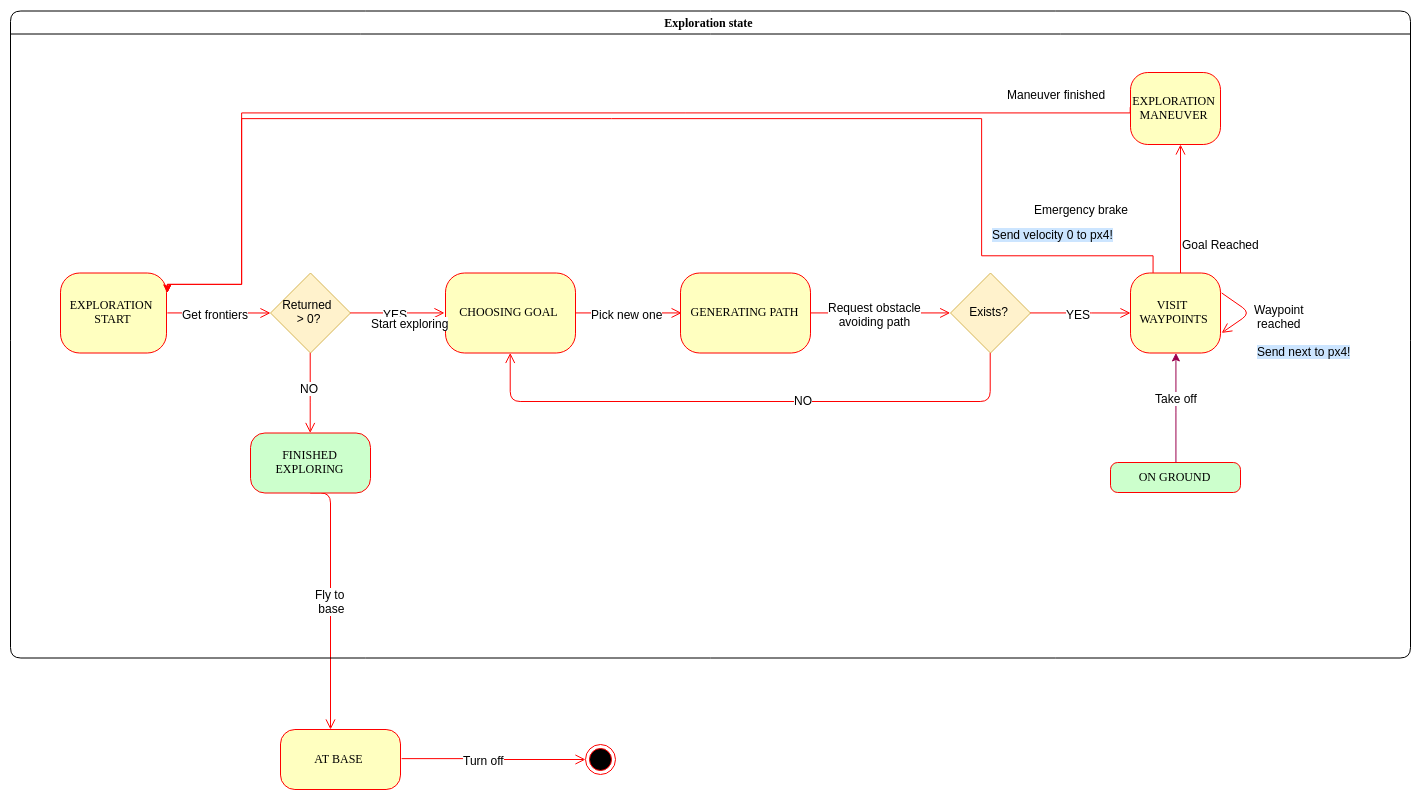

<a id='rosMysteries'></a>
### Ros Mysteries

- Catkin_simple
    - How to update the message generation on build package the imports them: update frontiers_msg with `catkin build frontiers`. Tried `cd_add_targets_to_package` but it adds the frontiers_msgs to the targets to install and fails.

<a id='mavros'></a>
### Mavros

- [ROS wiki](http://wiki.ros.org/mavros) 
`roslaunch mavros px4.launch`
- [Off board example](https://dev.px4.io/en/ros/mavros_offboard.html)
- mavlink_adapter 

##### Keeping the OffBoard mode:
[From px4](https://github.com/hamishwillee/px4_user_guide/blob/af0381dcdea989b6679200fe7a1b7c70468b82e5/en/flight_modes/offboard.md): Keep sending SET_POSITION_TARGET_LOCAL_NED messages

[From mavros](https://github.com/mavlink/mavros/search?utf8=%E2%9C%93&q=SET_POSITION_TARGET_LOCAL_NED&type=): This message is a PositionTarget.msg. set_position_target_local_ned() posts to topic local, which is consistent to what the [Off board example](https://dev.px4.io/en/ros/mavros_offboard.html) says.

##### Query param value
```
MPC_XY_VEL_MAX
param show MPC_XY_CRUISE
    Symbols: x = used, + = saved, * = unsaved
    x + MPC_XY_CRUISE [292,580] : 7.0000
     1055 parameters total, 654 used.
rosservice call /mavros/param/set "param_id: 'MPC_XY_CRUISE'
    value:
      integer: 0
      real: 7.0" 
```

<a id='px4'></a>
###### px4
- Opting out of px4 and mavros internal states as they are poorly documented. Especially in the case of Offboard mode. Instead arrival at waypoint will be checked with position. If trajectory generation is later implemented it will be controlled by time.

<a id='Octomap'></a>
### Octomap

**Free Space**

How to mark free space as free when there are no obstacles to make the return value within range? [ROS Answers question](https://answers.ros.org/question/287390/integrate-free-space-into-octomap/)

The existing ocotomap_server only inserts free space associated to the occupied points. To add also the free space associated with areas with no obstacles:
1. Have a sensor that inputs LaserScans, PointClouds2 does not have this information anymore - [model & plugin tutorial](http://moorerobots.com/blog/post/2)
2. Go through each of the ranges and pick up the free ones (either it is infinity or not defined, something)
3. Add each point to a PointCloud2 (beware of frames and transformations)
4. Change the octomap_server insert these scans as purely free space (like the occupied but no end point)

<a id='testing'></a>
### How to test

1. On an empty world make a geofence of min (-5, -5, 1) and max (5, 5, 10) and wait until all is explored.
2. On a world with a box (3m tall) make a geofence of min (-5, -5, 1) and max (5, 5, 10) and wait until all is explored.
1. On the world force_waypoint_sequence.world (two large block & a cilynder, geofence (-15, -20, 1) - (12, 20, 4):
    1. All the known voxels checked for a frontier are inside the safety margin wire box.
    1. The quad stays within the safety margin wire box at all times (except when arriving and leaving).
    1. The current position (light blue) is the same as the starting point (yellow).
    1. When all is explored and task finished, check the free voxels published by the octomap_server cover all reachable places within maneuver geofence.

3. On actinia world make a geofence of min (, , 1) and max (, , ) and wait until all is explored.

<a id='ObstacleAvoidance'></a>
### Obstacle Avoidance

- Think of octomap as Voronoi Map. Always using a resolution that guarantees safety. --> in path generation the corridor the quad flies through also needs to be checked.

<a id='toImplement'></a>
### To Implement

- Coverage calculation. Decide is an unknow cell is covered if it is unreachable. Decide the waypoint that needs to be visited to gather the information.
- Explore the relationship between:
    - the size of the vehicle 
    - the safety distance 
    - resolution needed to find all available paths 
    - number of line of sight checks needs to verify a path.

<a id='experiment'></a>
# Experiment

<a id='Simulation_environment'></a>
### Simulation environment
- Marine environment to make it relatable to Oceans
- Make it large so we can experiment with communication failures (>= 200)
- Actinia size 82m x 78m x 35m
- Check if it is interesting putting all together: RAM occupied by octree + size of path found (+ communications) 

<a id='Steps'></a>
### Steps
1. Set volume of the testbead. No prior knowledge
2. Just press go
3. Feed data into pix4d
4. Show map

<a id='dataset'></a>
### Dataset
- Bag
- Frontier selected
- Waypoints of each trajectory
- Octomap build

<a id='What_to_measure'></a>
### What to measure
- Coverage
- Flight time needed in autonomous mode
- Flight time and planning time needed in Pix4D
- Resolution
- Lazy Theta * iterations
- Lazy Theta * computation time for each waypoint
- RAM usage
- Exploration time
- Path lenght


<a id='hardware_setup'></a>
### Hardware setup

<a id='try1_asl'></a>
##### Try 1 - Used from ETHz ASL
1. Verify minimum range that is usable for Hokuyo. Both because of specs and if any part of the quad is obstructing the laser rays.
1. Check installed ubuntu version
    1. `lsb_release -a`
1. Install software
    1. `sudo apt-get update `
    1. `ssh-keygen -t rsa -b 4096 -C "margaridaCostaFaria@gmail.com"`
    1. `cat ~/.ssh/id_rsa.pub`
    1. Add to github
    1. `sudo sh -c 'echo "deb http://packages.ros.org/ros/ubuntu $(lsb_release -sc) main" > /etc/apt/sources.list.d/ros-latest.list'`
    1. `sudo apt-key adv --keyserver hkp://ha.pool.sks-keyservers.net:80 --recv-key 421C365BD9FF1F717815A3895523BAEEB01FA116`
    1. `sudo apt-get update`
    1. `sudo apt-get install ros-kinetic-desktop-full`
    1. `sudo rosdep init`
    1. `rosdep update`
    1. `echo "source /opt/ros/kinetic/setup.bash" >> ~/.bashrc`
    1. `source ~/.bashrc`
	1. `sudo sh -c 'echo "deb http://packages.ros.org/ros/ubuntu $(lsb_release -sc) main" > /etc/apt/sources.list.d/ros-latest.list'`
	1. `sudo apt-key adv --keyserver hkp://ha.pool.sks-keyservers.net:80 --recv-key 421C365BD9FF1F717815A3895523BAEEB01FA116`
	1. `wget http://packages.ros.org/ros.key -O - | sudo apt-key add - `
	1. `sudo apt-get update `
	1. `sudo apt-get install -y python-catkin-tools gdb ros-kinetic-octomap ros-kinetic-octomap-msgs ros-kinetic-octomap-server ros-kinetic-octomap-ros ros-kinetic-pcl-conversions ros-kinetic-pcl-ros geographiclib-tools rosbash ros-kinetic-rviz ros-kinetic-velodyne-simulator ros-kinetic-rqt-robot-plugins python-rospkg libqt4-dev ros-kinetic-geometry2 ros-kinetic-robot-state-publisher ros-kinetic-joint-state-publisher ros-kinetic-message-to-tf ros-kinetic-depthimage-to-laserscan ros-kinetic-tf2-kdl ros-kinetic-tf2-geometry-msgs ros-kinetic-pointcloud-to-laserscan ros-kinetic-nav-msgs git ros-kinetic-mavros-msgs ros-kinectic-urg-node-msgs`
	1. `sudo mkdir /Firmware `
	1. `cd /Firmware`
	1. `sudo wget https://raw.githubusercontent.com/mavlink/mavros/master/mavros/scripts/install_geographiclib_datasets.sh `
	1. `sudo chmod +x install_geographiclib_datasets.sh `
	1. `sudo  ./install_geographiclib_datasets.sh `
1. Check hardware
    1. `roscore`
    1. `rosrun urg_node urg_node _ip_address:=192.168.0.10`
1. Clone repos
    1. Clone FlyingOctomap folder
        1. `git clone https://github.com/margaridaCF/FlyingOctomap_code.git`
        1. `git checkout ____`
        1. `sudo mv FlyingOctomap_code Flying_Octomap_code`
        1. `cd Flying_Octomap_code`
        1. `git clone git@github.com:margaridaCF/laser_to_free_points_cloud.git`
        1. `cd laser_to_free_points_cloud/`
        1. `sudo git checkout free_cloud `
    1. Clone Firmware folder
        1. `sudo git clone https://github.com/PX4/Firmware.git`
        1. `cd Firmware/`
        1. `git checkout v1.7.0-rc4`

        1. `source /opt/ros/kinetic/setup.bash`
        1. `cd /ros_ws`
        2. `catkin init`
    1. `catkin build` 
1. Build following [px4](https://dev.px4.io/en/simulation/ros_interface.html) instructions - keep terminal
    1. `cd /Firmware`
    1. `wget https://raw.githubusercontent.com/mavlink/mavros/master/mavros/scripts/install_geographiclib_datasets.sh`
    1. `chmod +x install_geographiclib_datasets.sh`
    1. `./install_geographiclib_datasets.sh `
    1. `make posix_sitl_default gazebo`
    1. Kill process (this was just for the make part, they apperantly complicated the toolchain at px4)
    1. `source /ros_ws/devel/setup.bash`
    1. `source Tools/setup_gazebo.bash /Firmware /Firmware/build/posix_sitl_default`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware/Tools/sitl_gazebo`
    1. `cp /ros_ws/src/architecture/Tools/iris.xacro /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/`
    1. `cp /ros_ws/src/architecture/Tools/iris_base.xacro /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/`
    1. `cp /ros_ws/src/architecture/launch/posix_sitl_urdf.launch /Firmware/launch/`
    1. `python /Firmware/Tools/sitl_gazebo/scripts/xacro.py -o /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/iris_base.urdf /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/iris_base.xacro enable_mavlink_interface:=true enable_ground_truth:=false enable_wind:=false enable_logging:=false rotors_description_dir:=/Firmware/Tools/sitl_gazebo/models/rotors_description`
    1. `sed -i 's/package:\/\/rotors_description/package:\/\/mavlink_sitl_gazebo\/models\/rotors_description/g' /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/iris_base.urdf`
    1. Change the vertical angle of the rays in urdf `sed -i 's/_/_/g' /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/iris_base.urdf`
    1. `roslaunch px4 posix_sitl_urdf.launch`
    
1. Ssh  [**Troubleshooting**](https://dev.to/zduey/how-to-set-up-an-ssh-server-on-a-home-computer)
    1. Create (network manager - remember enter instead of add!) with ip 192.168.6.71 255.255.255.0 
    1. Connect to that one
    1. `sudo apt-get autoremove openssh-client`
    1. `sudo apt-get install openssh-client openssh-server`
    1. `ssh catec@192.168.6.70`
    
1. Mavros [port permissions](https://answers.ros.org/question/220319/ros-run-mavros-with-permission-denied/)
    1. `roslaunch mavros apm.launch`
    1. `sudo vim /opt/ros/kinetic/share/mavros/launch/px4.launch`
    1. Change port to appropriate - ttyS2 @ 921600 is the best guess
    1. `roslaunch mavros px4.launch`
    

<a id='try2_catec'></a>
###### Try 2. Same Firmware for SITL, Pixhawk and UAL. From laptop
** Installation **
1. Install ros on ground station pc
    1. `sudo apt-get install -y apt-transport-https ca-certificates curl  software-properties-common`
    1. `sudo apt-key adv --keyserver hkp://keyserver.ubuntu.com:80 --recv-keys 0DF731E45CE24F27EEEB1450EFDC8610341D9410`
    1. `wget -qO - https://download.sublimetext.com/sublimehq-pub.gpg | sudo apt-key add -
echo "deb https://download.sublimetext.com/ apt/stable/" | sudo tee /etc/apt/sources.list.d/sublime-text.list`
    1. `sudo add-apt-repository ppa:gnome-terminator`
    1. `sudo apt-get update`
    1. `sudo apt-get install -y sublime-text terminator git linux-image-generic linux-generic`
    1. `sudo apt-get -f install`
    1. `ssh-keygen -t rsa -b 4096 -C "margaridaCostaFaria@gmail.com"`
    1. `cat .ssh/id_rsa.pub`
    1. `cd ~`
    1. install Anaconda https://www.anaconda.com/download/#linux
    1. `bash ~/Downloads/Anaconda2-5.1.0-Linux-x86_64.sh`
    1. `curl -fsSL https://download.docker.com/linux/ubuntu/gpg | sudo apt-key add -`
    1. `sudo add-apt-repository \`
    1. `"deb [arch=amd64] https://download.docker.com/linux/ubuntu $(lsb_release -cs) stable`
    1. `$(lsb_release -cs) \stable"`
    1. `sudo apt-get update`
    1. `sudo apt-get install docker-ce`
    1. `sudo usermod -a -G docker $USER`
    1. (need to log out after this)
1. Install Ubuntu on Upboard and Ground station
    1. Verify minimum range that is usable for Hokuyo. Both because of specs and if any part of the quad is obstructing the laser rays.
    1. Check installed ubuntu version
        1. `lsb_release -a`
    1. Install software
        1. `sudo apt-get update `
        1. `ssh-keygen -t rsa -b 4096 -C "margaridaCostaFaria@gmail.com"`
        1. `cat ~/.ssh/id_rsa.pub`
        1. Add to github
        1. `sudo sh -c 'echo "deb http://packages.ros.org/ros/ubuntu $(lsb_release -sc) main" > /etc/apt/sources.list.d/ros-latest.list'`
        1. `sudo apt-key adv --keyserver hkp://ha.pool.sks-keyservers.net:80 --recv-key 421C365BD9FF1F717815A3895523BAEEB01FA116`
        1. `sudo apt-get update`
        1. `sudo apt-get install ros-kinetic-desktop-full`
        1. `sudo rosdep init`
        1. `rosdep update`
        1. `echo "source /opt/ros/kinetic/setup.bash" >> ~/.bashrc`
        1. `source ~/.bashrc`
        1. `sudo sh -c 'echo "deb http://packages.ros.org/ros/ubuntu $(lsb_release -sc) main" > /etc/apt/sources.list.d/ros-latest.list'`
        1. `sudo apt-key adv --keyserver hkp://ha.pool.sks-keyservers.net:80 --recv-key 421C365BD9FF1F717815A3895523BAEEB01FA116`
        1. `wget http://packages.ros.org/ros.key -O - | sudo apt-key add - `
        1. `sudo apt-get update `
        1. `sudo apt-get install -y python-catkin-tools gdb ros-kinetic-octomap ros-kinetic-octomap-msgs ros-kinetic-octomap-server ros-kinetic-octomap-ros ros-kinetic-pcl-conversions ros-kinetic-pcl-ros geographiclib-tools rosbash ros-kinetic-rviz ros-kinetic-velodyne-simulator ros-kinetic-rqt-robot-plugins python-rospkg libqt4-dev ros-kinetic-geometry2 ros-kinetic-robot-state-publisher ros-kinetic-joint-state-publisher ros-kinetic-message-to-tf ros-kinetic-depthimage-to-laserscan ros-kinetic-tf2-kdl ros-kinetic-tf2-geometry-msgs ros-kinetic-pointcloud-to-laserscan ros-kinetic-nav-msgs git ros-kinetic-mavros-msgs ros-kinectic-urg-node-msgs ros-kinetic-node-manager-fkie ros-kinetic-multimaster-fkie ros-kinetic-cmake-modules exfat-fuse exfat-utils ros-kinetic-laser-filters`
1. **Upboard **
    1. Auto login
    1. Add at the top of bashrc source /opt/ros/kinetic/setup.bash and source ~/.bashrc
1. **Ground station **
    1. `pip install catkin_pkg`
    1. `pip uninstall em`
    1. `pip install empy`
    1. `pip install plotly`
    1. `pip install cufflinks`
    1. Add host name & ip to /etc/hosts in Ground Station. This is the first lookup done before resorting to DNS, so it knowns the ip corresponding to hostname, since the node manager runs the ssh command with hostname instead of ip `192.168.6.231   catec-UP-CHT01`
1. Clone FlyingOctomap folder **@ laptop & upboard**
    1. `git clone git@github.com:margaridaCF/FlyingOctomap_code.git`
    1. `git checkout ____`
    1. `mv FlyingOctomap_code Flying_Octomap_code`
    1. `cd Flying_Octomap_code`
    1. `git clone git@github.com:margaridaCF/laser_to_free_points_cloud.git`
    1. `cd laser_to_free_points_cloud/`
    1. `git checkout free_cloud `
    1. Change paths for folders at Upboard
        1. `sed -i -- 's/\/ros_ws\/src\/data/\/home\/catec\/ros_ws\/src\/data/g' ~/ros_ws/src/architecture/src/state_manager_node.cpp`
        1. `find ~/ros_ws/src -type f -exec sed -i 's/\/ros_ws\/src\/data/\/home\/catec\/ros_ws\/src\/data/g' {} +`
    1. `export PYTHONPATH=$PYTHONPATH:/usr/lib/python2.7/dist-packages`
        
1. Build firmware to flash Pixhawk **@ laptop & upboard**
    1. Build 
        1. `sudo apt install -y cmake genromfs python-empy catkin_pkg`
        1. `pip uninstall em`
        1. `pip install numpy toml empy`
        1. `sudo usermod -a -G dialout $USER`
        1. `wget https://raw.githubusercontent.com/PX4/Devguide/master/build_scripts/ubuntu_sim_nuttx.sh`
        1. `chmod +x ubuntu_sim_nuttx.sh`
        1. `./ubuntu_sim_nuttx.sh` 
        1. `cd ~/src/Firmware`
        1. `git checkout v1.7.3`
        1. `make px4fmu-v2_default`
    1. Flash **laptop connected to Pixhawk** to have gui
        1. `cd /home/mfaria/qgroundcontrol`
        1. `./qgroundcontrol-start.sh`
        1. Build file is ~/src/Firmware/build/px4fmu-v2_default/px4fmu-v2_default.px4
        1. Set parameter Companion
        1. Callibrate
        
1. Run to fly **@ upboard** connected to laptop through ethernet to rocket
    1. "Edit connections" on laptop to have static ip 192.168.6.71
    1. `ssh catec@192.168.6.321`
    1. (test mavros) `roslaunch mavros px4.launch`
    1. (grounded vehicle) `roslaunch architecture realUav_onGround.launch`
    
1. Simulation setup **@ laptop**
    2. Build docker image
        1. `cd ~/Flying_Octomap_code/src/_docker`
        1. `docker build -t garuda_pixhawk .` 
    3. Launch docker
        1. `xhost +`
        1. `docker run -it --privileged \
        -v ~/Firmware:/Firmware:rw \
        -v ~/Flying_Octomap_code/src:/ros_ws/src:rw \
        -v /tmp/.X11-unix:/tmp/.X11-unix:ro \
        -e DISPLAY=:0 \
        --name=garuda_pixhawk garuda_pixhawk /bin/bash`
        1. exit
        1. `docker start garuda_pixhawk`
        1. `docker exec -u 0 -it garuda_pixhawk bash`
        
    1. Build ros workspace
        1. (First time) Make ros workspace:
            1. `cd /Firmware`
            1. `source /opt/ros/kinetic/setup.bash`
            1. `cd /ros_ws`
            2. `catkin init`
        1. `catkin build` 
    1. Build following [px4](https://dev.px4.io/en/simulation/ros_interface.html) instructions - keep terminal
        1. `cd /Firmware`
        1. `wget https://raw.githubusercontent.com/mavlink/mavros/master/mavros/scripts/install_geographiclib_datasets.sh`
        1. `chmod +x install_geographiclib_datasets.sh`
        1. `./install_geographiclib_datasets.sh `
        1. `make posix_sitl_default gazebo`
        1. Kill process (this was just for the make part, they apperantly complicated the toolchain at px4)
        1. `source /ros_ws/devel/setup.bash`
        1. `source Tools/setup_gazebo.bash /Firmware /Firmware/build/posix_sitl_default`
        1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware`
        1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware/Tools/sitl_gazebo`
        1. `cp /ros_ws/src/architecture/Tools/iris.xacro /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/`
        1. `cp /ros_ws/src/architecture/Tools/iris_base.xacro /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/`
        1. `cp /ros_ws/src/architecture/launch/posix_sitl_urdf.launch /Firmware/launch/`
        1. `python /Firmware/Tools/sitl_gazebo/scripts/xacro.py -o /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/iris_base.urdf /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/iris_base.xacro enable_mavlink_interface:=true enable_ground_truth:=false enable_wind:=false enable_logging:=false rotors_description_dir:=/Firmware/Tools/sitl_gazebo/models/rotors_description`
        1. `sed -i 's/package:\/\/rotors_description/package:\/\/mavlink_sitl_gazebo\/models\/rotors_description/g' /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/iris_base.urdf`
        1. `roslaunch px4 posix_sitl_urdf.launch`
        


** Network @ CATEC to UAV **
- Laptop through wired network.
- 192.168.6.232 through wired network. (Rocket 2)
- 192.168.6.231 through wireless to 192.168.6.232 (Rocket 1)
- 192.168.6.230 through ethernet to 192.168.6.231 (Upboard)


** Run **
1. Simulation
    1. `docker start garuda_pixhawk`
    1. `xhost +`
    1. `docker exec -u 0 -it garuda_pixhawk bash`
    1. `cd /Firmware`
    1. `source /ros_ws/devel/setup.bash`
    1. `source Tools/setup_gazebo.bash /Firmware /Firmware/build/posix_sitl_default`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware/Tools/sitl_gazebo`
    1. `cp /ros_ws/src/architecture/Tools/iris.xacro /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/`
    1. `cp /ros_ws/src/architecture/Tools/iris_base.xacro /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/`
    1. `cp /ros_ws/src/architecture/launch/posix_sitl_urdf.launch /Firmware/launch/`
    1. `python /Firmware/Tools/sitl_gazebo/scripts/xacro.py -o /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/iris_base.urdf /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/iris_base.xacro enable_mavlink_interface:=true enable_ground_truth:=false enable_wind:=false enable_logging:=false rotors_description_dir:=/Firmware/Tools/sitl_gazebo/models/rotors_description`
    1. `sed -i 's/package:\/\/rotors_description/package:\/\/mavlink_sitl_gazebo\/models\/rotors_description/g' /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/iris_base.urdf`
    1. `roslaunch px4 posix_sitl_urdf.launch`
    1. `roslaunch mavros px4.launch fcu_url:="udp://:14540@127.0.0.1:14557"`    
    
1. Grounded UAV
    1. `ssh catec@192.168.6.321`
    1. `cd /row_ws`
    1. `source devel/setup.bash`
    1. `roslaunch architecture realUav_onGround.launch`
1. Fly
    1. **Ground station** `export ROS_MASTER_URI=http://192.168.6.231:11311`
    1. **UAV** `http://localhost:11311`
    1. **UAV** `roslaunch architecture realUav_fly.launch`
    1. **Ground station** `rviz`
    1. Change rviz to `realUAV.rviz`
    1. Save logs
        1. Plug external drive on UAV
        1. mkdir at karting experiments
        1. move all logs there
        1. `sudo unmount /media/catec/Ganesha/`
        1. If it is blocked check terminal is not inside Ganesha then ` lsof /media/catec/Ganesha/` to find pid that is blocking.
        1. `cd /ros_ws/src/data`
        1. `rm -r *`

1. On ground station `export ROS_MASTER_URI=http://192.168.6.231:11311`
1. On UAV `roslaunch mavros px4.launch`
1. On ground station `rviz`

<a id='hitl'></a>
### Hardware in the Loop

This applies after experimental testing setup is available and running. instructions (except docker) [here](#try2_catec)

###### Try 1 - Docker + laptop + UAV
- **Docker** px4 simulation. Direct the mavros stream to UAV with distributed ros
- **UAV** UpBoard. The point is to understand the processing power of UpBoard. Run the nodes peveloped here.
- **Laptop** monitoring & recording bag. It will do the same as in the field (rviz & bag recording) 

1. Simulation setup **@ laptop**
    2. **Laptop** Build docker image
        1. `cd ~/Flying_Octomap_code/src/_docker`
        1. `docker build -t garuda_pixhawk .` 
        1. :( `docker network create --subnet=192.168.6.0/24 rocketUAVnet`
        1. `docker run -it --privileged \
        -v ~/Firmware:/Firmware:rw \
        -v ~/Flying_Octomap_code/src:/ros_ws/src:rw \
        -v /tmp/.X11-unix:/tmp/.X11-unix:ro \
        -e DISPLAY=:0 \
        --network="host" \
        --name=garuda_pixhawk_hil garuda_pixhawk /bin/bash`
    3. **Laptop** Launch docker
        1. `xhost +`
        1. exit
        1. `docker start garuda_pixhawk_hil`
        1. `docker exec -u 0 -it garuda_pixhawk_hil bash`
        
    1. **Docker** Build px4 simulation
        1. Build ros workspace
            1. (First time) Make ros workspace:
                1. `source /opt/ros/kinetic/setup.bash`
                1. `cd /ros_ws`
                1. `git status`
                1. `git checkout hil`
                2. `catkin init`
            1. `catkin build` 
        1. `cd /Firmware`
        1. `source /opt/ros/kinetic/setup.bash`
        1. `wget https://raw.githubusercontent.com/mavlink/mavros/master/mavros/scripts/install_geographiclib_datasets.sh`
        1. `chmod +x install_geographiclib_datasets.sh`
        1. `./install_geographiclib_datasets.sh `
        1. `make posix_sitl_default gazebo`
        1. Kill process (this was just for the make part, they apperantly complicated the toolchain at px4)
        1. `source /ros_ws/devel/setup.bash`
        1. `source Tools/setup_gazebo.bash /Firmware /Firmware/build/posix_sitl_default`
        1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware`
        1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware/Tools/sitl_gazebo`
        1. `cp /ros_ws/src/architecture/Tools/iris.xacro /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/`
        1. `cp /ros_ws/src/architecture/Tools/iris_base.xacro /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/`
        1. `cp /ros_ws/src/architecture/launch/posix_sitl_urdf.launch /Firmware/launch/`
        1. `python /Firmware/Tools/sitl_gazebo/scripts/xacro.py -o /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/iris_base.urdf /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/iris_base.xacro enable_mavlink_interface:=true enable_ground_truth:=false enable_wind:=false enable_logging:=false rotors_description_dir:=/Firmware/Tools/sitl_gazebo/models/rotors_description`
        1. `sed -i 's/package:\/\/rotors_description/package:\/\/mavlink_sitl_gazebo\/models\/rotors_description/g' /Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/iris_base.urdf`
        1. `export ROS_IP=192.168.6.77`
        1. `export ROS_MASTER_URI=http://192.168.6.231:11311`
    1. Launch px4 simulation
        1. **UpBoard** `export ROS_IP=192.168.6.231 & roslaunch px4 posix_hitl_upboard.launch`
        1. **Docker** `cd /Firmware`
        1. `source /opt/ros/kinetic/setup.bash`
        1. `source /ros_ws/devel/setup.bash`
        1. `source Tools/setup_gazebo.bash /Firmware /Firmware/build/posix_sitl_default`
        1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware`
        1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware/Tools/sitl_gazebo`
        1. `export ROS_IP=192.168.6.77`
        1. `export ROS_MASTER_URI=http://192.168.6.231:11311`
        1. `roslaunch px4 posix_hitl_docker.launch`
        1. `roslaunch mavros px4.launch fcu_url:="udp://:14540@127.0.0.1:14557"`  
        
        
        
###### Try 2 - Laptop + UAV
- **UAV** UpBoard. The point is to understand the processing power of UpBoard. Run the nodes peveloped here.
- **Laptop** 
    - monitoring & recording bag. It will do the same as in the field (rviz & bag recording)
    - px4 simulation. Direct the mavros stream to UAV with distributed ros

1. Simulation setup **@ laptop**
    1. **Laptop** Build px4 simulation
        1. Build ros workspace
            1. (First time) Make ros workspace:
                1. `source /opt/ros/kinetic/setup.bash`
                1. `cd ~/Flying_Octomap_code/src`
                1. `git status`
                1. `git checkout hil`
                2. `catkin init`
            1. `catkin build` 
        1. `cd ~/src/Firmware`
        1. `source /opt/ros/kinetic/setup.bash`
        1. `source ubuntu_sim_ros_gazebo.sh` [link](https://raw.githubusercontent.com/PX4/Devguide/master/build_scripts/ubuntu_sim_ros_gazebo.sh)
        1. `make posix_sitl_default gazebo`
        1. Kill process (this was just for the make part, they apperantly complicated the toolchain at px4)
        1. `source ~/Flying_Octomap_code/devel/setup.bash`
        1. `source Tools/setup_gazebo.bash ~/src/Firmware ~/src/Firmware/build/posix_sitl_default`
        1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:~/src/Firmware`
        1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:~/src/Firmware/Tools/sitl_gazebo`
        1. `cp ~/Flying_Octomap_code/src/architecture/Tools/iris.xacro ~/src/Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/`
        1. `cp ~/Flying_Octomap_code/src/architecture/Tools/iris_base.xacro ~/src/Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/`
        1. `python ~/src/Firmware/Tools/sitl_gazebo/scripts/xacro.py -o ~/src/Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/iris_base.urdf ~/src/Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/iris_base.xacro enable_mavlink_interface:=true enable_ground_truth:=false enable_wind:=false enable_logging:=false rotors_description_dir:=/home/garuda/src/Firmware/Tools/sitl_gazebo/models/rotors_description`
        1. `sed -i 's/package:\/\/rotors_description/package:\/\/mavlink_sitl_gazebo\/models\/rotors_description/g' ~/src/Firmware/Tools/sitl_gazebo/models/rotors_description/urdf/iris_base.urdf`
        1. `export ROS_IP=192.168.6.77`
        1. `export ROS_MASTER_URI=http://192.168.6.231:11311`
        
    1. Launch px4 simulation

        1. **UpBoard** `export ROS_IP=192.168.6.231 & roslaunch architecture posix_hitl_upboard.launch`
        1. **Laptop** `cd ~/src/Firmware`
        1. `source /opt/ros/kinetic/setup.bash`
        1. `source ~/Flying_Octomap_code/devel/setup.bash`
        1. `source Tools/setup_gazebo.bash ~/src/Firmware ~/src/Firmware/build/posix_sitl_default`
        1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:~/src/Firmware`
        1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:~/src/Firmware/Tools/sitl_gazebo`
        1. `export ROS_IP=192.168.6.77`
        1. `export ROS_MASTER_URI=http://192.168.6.231:11311`
        1. `roslaunch architecture posix_hitl_docker.launch`
        1. `roslaunch mavros px4.launch fcu_url:="udp://:14540@127.0.0.1:14557"`  

<a id='test_instructions'></a>
# Instructions to test

### Simulation
1. New terminal with ros_ws
    1. `docker start garuda_sitl_v2`
    1. `xhost +`
    1. `docker exec -u 0 -it garuda_sitl_v2 bash`
    1. `cd /Firmware`
    1. `source /ros_ws/devel/setup.bash`
    1. `source Tools/setup_gazebo.bash /Firmware /Firmware/build/posix_sitl_default`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware`
    1. `export ROS_PACKAGE_PATH=$ROS_PACKAGE_PATH:/Firmware/Tools/sitl_gazebo`
1. Setup data scripts
    1. `cp ../architecture/Tools/save_free_mem.bash .`
    1. `chmod a+x save_free_mem.bash`
    1. clean data folder
1. Run in separate terminals
    1. `roslaunch px4 posix_sitl_urdf.launch` @ Firmaware
    1. `save_free_mem.bash` @ src/data
    1. `roslaunch mavros px4.launch fcu_url:="udp://:14540@127.0.0.1:14557"` @ Firmware
1. Post process @ data
    1. `mv ram.csv current`
    1. `rm current`

### Real

1. `vim /opt/ros/kinetic/share/mavros/launch/px4_config.yaml`
1. `roslaunch mavros px4.launch`
1. `rostopic echo /tf`

https://docs.px4.io/en/sensor/rangefinders.html

<a id='data_analysis'></a>
# Data analysis

### Save data to external drive
1. cd to data
1. `sudo chown mfaria: *`
1. remove all : characters from names
1. `cp -R *  /media/mfaria/Ganesha/20171219_backup_home_catec/Margarida/__folder__`

### Run plotly
1. Installation
    1. `pip install plotly`
    1. `pip install cufflinks`
1. Run frontier extraction for box plots
    1. `cd ~/Flying_Octomap_code/_generate_plots`
    1. `python`
    1. `variables= {}`
    1. `execfile( "compare_box_graphs.py", variables )`

Each approach run 20 to 50 times.
[Boxplot](https://plot.ly/python/box-plots/)

1. Explored volume vs. time (linear plot)
1. Explored volume vs. distance (linear plot)
1. Exploration time. Boxplot
1. Computation time of the different parts and overall. Boxplot

From "History-aware Autonomous Exploration in Confined Environments using MAVs."
- Exploration time
- Max computation time
- Volume covered vs time
- Volume covered vs distance


<a id='thinkpad'></a>
### Thinkpad

##### Octomap cell size vs quad size
This particular application can work with coarse maps ==> minimum cell size can be equal or even bigger than quad size. Which usually is not the case for rooms, labs and smaller scale applications.

##### Yaw rate vs octomap resolution vs laser range

##### Laser range vs minimum distances from goal vs loiter range
The minimum distance from current position of a goal right now is only related to the acceptance range of px4. The minimum laser range must also be taken into account.
Use the same setting both for filtering out the propellers at point cloud level and meetsOperationalRequirements in frontier lib.

##### Fast exploration due to flight endurance can be overcome with battery switching

##### Put scale into maps!


###### Laser range vs laser tilt vs xy reach

In [15]:
import math
laser_range = 15
laser_tilt = 0.872665
xy_reach = laser_range*math.cos(laser_tilt)

print "10m range = " + str(10*math.cos(laser_tilt))
print "15m range = " + str(xy_reach)
print "20m range = " + str(20*math.cos(laser_tilt))

10m range = 6.42787323184
15m range = 9.64180984776
20m range = 12.8557464637


###### Sensor model rectangle

 I also wanted to know if you know of examples of geometric modeling of the reach of the sensor to sample within the sensor swath.
 This is the swath generated when going in a straight line from one waypoint to the next.
 The disc is always perpendicular to the straight line that is the trajectory between two waypoints. this disk is also tilted 50º upwards.
 
 There is a fair amount of details to be thought of here and I'm only now starting to dive into it so was wondering what are your first thoughts on using the approach of using the octomap resolution like in the free corridor :
 - X, Y, Z bounds. Project the tilted disc into a rectangle in XZ in the UAV coordinate frame, where positive x is forward. The rectangle would be centered on the UAV.
 - Discretization. Using octomap resolution (as it is done for the flight corridor) does not scale well to a 23x30m corridor. (the Hokuyo has 15m range and is tilted, with the projection into YZ the disc turns into ellipsoid). It needs ~2771 raycasts to cover everything (height * length / octomap_resolution).       
      This is an operation that I'll be doing to calculate node heuristics so it has to be super fast.      
      If I cut a few corners and reduce the corridor to 18 x 24 m centered on the UAV (which has the benefit of avoiding voxels outside of the sensor range because the ellipsoid is being approximated with a rectangle) I lower the raycast count to ~1774. Which is still a bit high.        
      Another thing I ?can? relax is the discretization resolution, by using double the octomap resolution I get to ~551. 
 - Disk dent. I'm not sure if it is worth it or not to keep all the time checking for the dent. I was think of checking this with polar coordinates like Angle = arctan(y/x); Radius = sqrt(x * x + y * y) and finally checking the angle.
 
Need to decide: 
- is the discretization step too big? 
- Is there a better model for sampling that is still deterministic? 
- Assuming ~550 ray casts to take around 50millis, reasonable? 
- Disk dent - worth it to include in the model?

In [65]:
import math
experiment_scaling = 1.607843137
octomap_resolution = 0.4
sensor_model_scale = 0.2
sparse_ratio = 2
sparse_sampling_resolution = (octomap_resolution*sparse_ratio)
print "Sparse Ratio " + str(sparse_ratio) 
print "sparse_sampling_resolution " + str(sparse_sampling_resolution)
# Karting
print "== Karting =="
laser_range = 15 / experiment_scaling
print "laser range = " + str(laser_range ) + " m"

laser_tilt = 0.872665
yz_reach = laser_range*math.sin(laser_tilt)
print "yz range    = " + str(yz_reach) + " m"

height = yz_reach * 2
length = laser_range * 2
print "- Full sensor model.     " + str(height) + " x " + str(length)
print "ray casts   = " + str(height*length/octomap_resolution)
height = height - (height*sensor_model_scale)
length = length - (length*sensor_model_scale)
print "- Subset of laser model. " + str(height) + " x " + str(length)
print "ray casts   = " + str(height*length/octomap_resolution)
print "- Sparse sampling of model. "
print "ray casts   = " + str(height*length/ sparse_sampling_resolution  )


#Actinia
print "== Actinia =="
octomap_resolution = octomap_resolution / experiment_scaling
print " octomap resolution = " + str( octomap_resolution ) + " m"

laser_range = 15 
print " laser range = " + str(laser_range ) + " m"

laser_tilt = 0.872665
yz_reach = laser_range*math.sin(laser_tilt)
print " yz range    = " + str(yz_reach) + " m"

height = yz_reach * 2
length = laser_range * 2
print " - Full sensor model.     " + str(height) + " x " + str(length)
print " ray casts   = " + str(height*length/octomap_resolution)
height = height - (height*sensor_model_scale)
length = length - (length*sensor_model_scale)
print " - Subset of laser model. " + str(height) + " x " + str(length)
print " ray casts   = " + str(height*length/octomap_resolution)
print " - Sparse sampling of model." 
print " ray casts   = " + str(height*length/ sparse_sampling_resolution  )


Sparse Ratio 2
sparse_sampling_resolution 0.8
== Karting ==
laser range = 9.32926829416 m
yz range    = 7.14663637791 m
- Full sensor model.     14.2932727558 x 18.6585365883
ray casts   = 666.728881703
- Subset of laser model. 11.4346182046 x 14.9268292707
ray casts   = 426.70648429
- Sparse sampling of model. 
ray casts   = 213.353242145
== Actinia ==
 octomap resolution = 0.248780487844 m
 laser range = 15 m
 yz range    = 11.4906702528 m
 - Full sensor model.     22.9813405057 x 30
 ray casts   = 2771.27929584
 - Subset of laser model. 18.3850724046 x 24.0
 ray casts   = 1773.61874934
 - Sparse sampling of model.
 ray casts   = 551.552172137


<a id='Implementation'></a>
# Implementation details
Check from JINT

### Heuristic to goal's voxel center or just goal?

### Line of sight going through explored terrain?

<a id='Milestones'></a>
# Milestones

1. Simulation
    1. Large mostly open space
    1. Maze
    1. Actinia
    1. Atlas

1. Experimental
    1. Hardware
    1. Autonomous flight + architecture
    1. \+ Generate mesh
    1. \+ RTK
    1. Data collection

<a id='References'></a>
# References



- Journal of Field Robotics prev implementation
- JINT / ICUAS
- octomap
- gazebo
- ros 
 
 ```@ARTICLE {rotors:2016,
    author  = "Fadri Furrer and Michael Burri and Markus Achtelik and Roland Siegwart",
    title   = "Robot Operating System (ROS)",
    journal = "Studies Comp.Intelligence Volume Number:625",
    year    = "2016",
    volume  = "The Complete Reference (Volume 1)",
    number  = "978-3-319-26052-5",
    pages   = "Chapter 23",
    note    = "ISBN:978-3-319-26052-5"```
}
- tf library 

```@inproceedings {6556373,
    title = {tf: The transform library},
    booktitle = {Technologies for Practical Robot Applications (TePRA), 2013 IEEE International Conference on},
    series = {Open-Source Software workshop},
    year = {2013},
    month={April}, 
    pages={1-6}, 
    author = {Foote, Tully},
    doi={10.1109/TePRA.2013.6556373}, 
    ISSN={2325-0526}
}```

```
@INPROCEEDINGS{7353622,
author={M. Burri and H. Oleynikova and M. W. Achtelik and R. Siegwart},
booktitle={2015 IEEE/RSJ International Conference on Intelligent Robots and Systems (IROS)},
title={Real-time visual-inertial mapping, re-localization and planning onboard MAVs in unknown environments},
year={2015},
volume={},
number={},
pages={1872-1878},
keywords={autonomous aerial vehicles;distance measurement;inertial systems;microrobots;path planning;robot vision;IMU measurements;dynamic 3D paths;globally consistent map;onboard MAV;real-time visual-inertial mapping;unknown environments;visual-inertial odometry;Buildings;Cameras;Helicopters;Inspection;Planning;Real-time systems;Visualization},
doi={10.1109/IROS.2015.7353622},
ISSN={},
month={Sept},}
```